In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, GroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve,roc_auc_score, f1_score

In [2]:
from pandas.errors import SettingWithCopyWarning
import warnings
warnings.filterwarnings('ignore', category=SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)



### importing dataSets


In [3]:
# importing train dataset and assigning data types to avoid memory error since it's a too large dataset

dtypes={
    'session_id': np.int32, 
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}

train_df = pd.read_csv("train.csv")
train_df.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


#### Shape of the Train dataset

In [4]:
print(train_df.shape)

(26296946, 20)


In [5]:
# checking null values
train_df.isna().sum()

session_id               0
index                    0
elapsed_time             0
event_name               0
name                     0
level                    0
page              25732402
room_coor_x        2073272
room_coor_y        2073272
screen_coor_x      2073272
screen_coor_y      2073272
hover_duration    24294702
text              16679807
fqid               8274415
room_fqid                0
text_fqid         16679702
fullscreen               0
hq                       0
music                    0
level_group              0
dtype: int64

### visualizing null values by each column

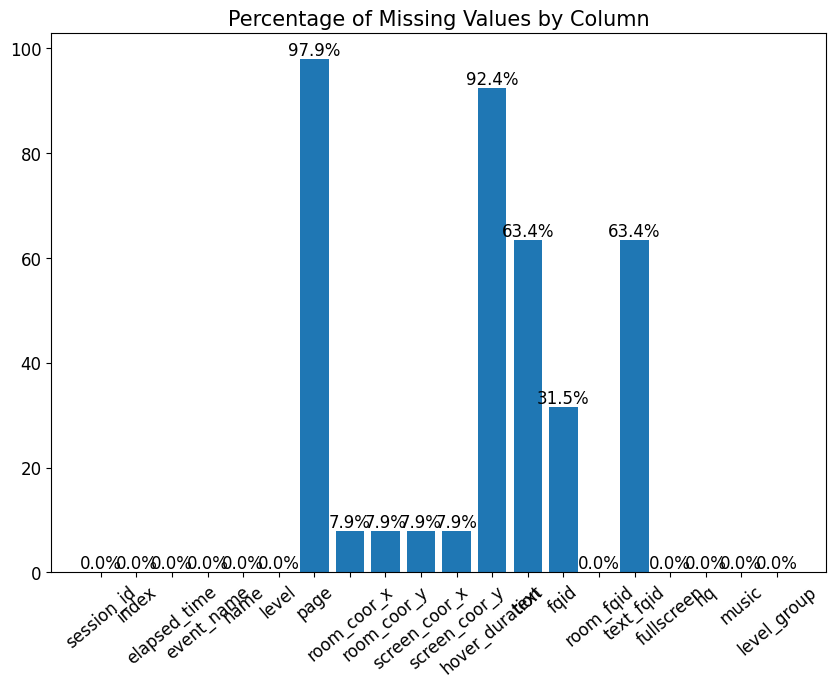

In [5]:
train_missing = train_df.isna().mean()* 100
train_missing_index = train_missing.index
train_missing_values = train_missing.values

fig, ax = plt.subplots(figsize=(10, 7))
barchart = ax.bar(x=train_missing_index, height=train_missing_values)
ax.set_title("Percentage of Missing Values by Column", fontsize=15, loc='center')
ax.bar_label(barchart, fmt="%.1f%%", fontsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(rotation=40, labelsize=12)
plt.show()


#### Correlation 

C:\Users\Mahmudul\AppData\Local\Temp\ipykernel_19436\45835331.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_df.corr()


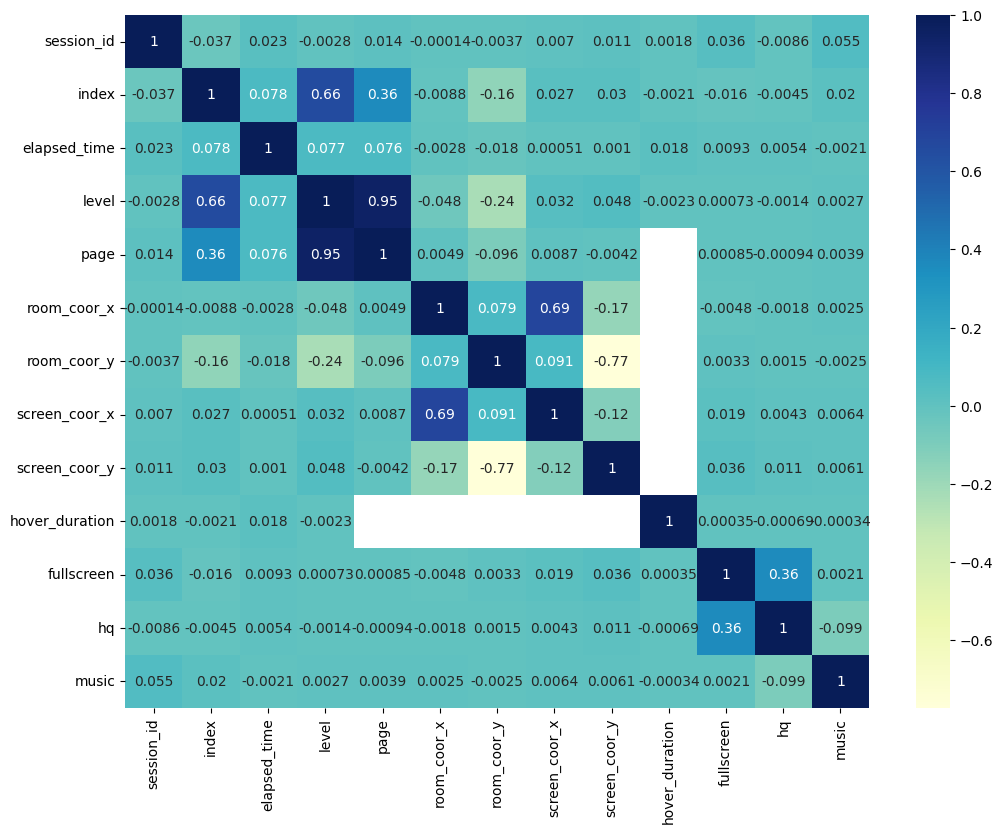

In [6]:

corr = train_df.corr()

# create correlation heatmap with modified figure size
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, annot=True, cmap="YlGnBu", ax=ax)

# show the plot
plt.show()

In [4]:
# importing train labels data

target = pd.read_csv('train_labels.csv')
target['session'] = target.session_id.apply(lambda s: int(s.split('_')[0]))
target['q'] = target.session_id.apply(lambda s: int(s.split('_')[1][1:]))
target = target.drop('session_id', axis=1)

print('label shape:',target.shape)
target.head()

label shape: (424116, 3)


,correct,session,q
0,1,20090312431273200,1
1,0,20090312433251036,1
2,1,20090312455206810,1
3,0,20090313091715820,1
4,1,20090313571836404,1


#### checking whether is label balanced or imbalanced

<Axes: >

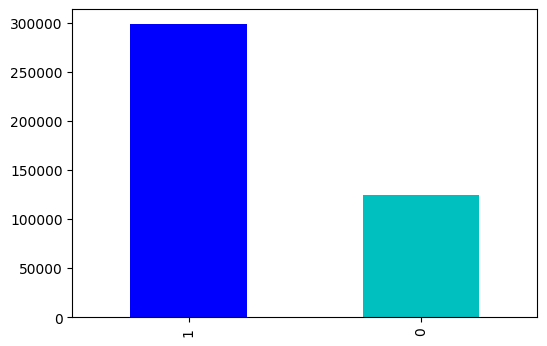

In [7]:
# checking whether is label balanced or imbalanced
plt.figure(figsize=(6, 4))
plot_df = target.correct.value_counts()
plot_df.plot(kind="bar", color=['b', 'c'])

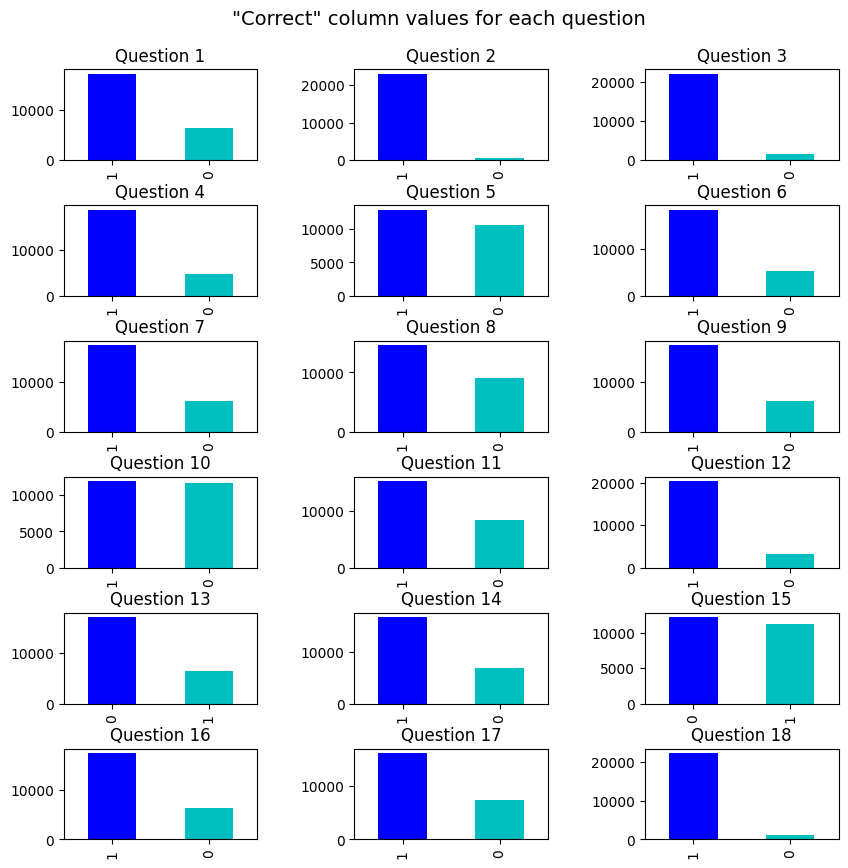

In [9]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("\"Correct\" column values for each question", fontsize=14, y=0.94)
for n in range(1,19):
    #print(n, str(n))
    ax = plt.subplot(6, 3, n)

    # filter df and plot ticker on the new subplot axis
    plot_df = target.loc[target.q == n]
    plot_df = plot_df.correct.value_counts()
    plot_df.plot(ax=ax, kind="bar", color=['b', 'c'])
    
    # chart formatting
    ax.set_title("Question " + str(n))
    ax.set_xlabel("")

### Data Preprocessing

In [36]:
# splitting categorical and numerical columns separately
categorical = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
numerical = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']
events = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']

In [37]:
def data_processing(data):
    dfs = []
    for c in categorical:
        tmp = data.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in numerical:
        tmp = data.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in numerical:
        tmp = data.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)

    for c in numerical:
        tmp = data.groupby(['session_id','level_group'])[c].agg('max')-data.groupby(['session_id','level_group'])[c].agg('min')
        tmp.name = tmp.name + '_delta'
        dfs.append(tmp)
    for c in categorical:
        tmp = data.groupby(['session_id','level_group'])[c].agg('count')
        tmp.name = tmp.name + '_count'
        dfs.append(tmp)
    for c in events: 
        data[c] = (data.event_name == c).astype('int8')
    for c in events + ['elapsed_time']:
        tmp = data.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    
    data = pd.concat(dfs,axis=1)
    data = data.fillna(-1)
    data = data.reset_index()
    data= data.set_index('session_id')
    return data

#### Processing train data

In [38]:
datasets = data_processing(train_df) 
print(datasets.shape)

(70686, 45)


In [13]:
datasets.head()

,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,...,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.0,7.701275,...,81,22,28,11,4,8,2,4,1,14155937
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.0,-130.347170,...,170,123,60,20,14,10,6,3,1,437052322
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.0,14.306062,...,103,104,12,28,9,9,8,1,1,105732736
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.0,-84.045960,...,49,18,36,15,3,5,3,2,1,13571045
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.1,-30.762282,...,637,145,65,83,186,14,45,5,1,3241011333


#### Defing features

In [39]:
# Define features 
features = [c for c in datasets.columns if c != 'level_group']
all_users = datasets.index.unique()
print('We will train with', len(features) ,'features and ', len(all_users) ,'users info')

We will train with 44 features and  23562 users info


### Support Vector Machine 

In [ ]:


# define the number of folds
n_folds = 5

# create a KFold object
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# create an empty list to store the fold accuracies
fold_accuracies = []
accuracies = []
fold_f1_scores = []
# loop over the folds
for fold, (train_index, valid_index) in enumerate(kf.split(datasets)):
    
    # split the dataset into training and validation sets
    train_x = datasets.iloc[train_index]
    valid_x = datasets.iloc[valid_index]

    # create a dictionary to store the accuracies and f1 score for this fold
    fold_dict = {}
    evaluation_dict = {}
    fold_f1_dict = {}
    # Loop through each question
    for q_no in range(1,19):

        question_acc = []
        question_f1 = []
        # Select level group for the question based on the q_no.
        if q_no<=3: grp = '0-4'
        elif q_no<=13: grp = '5-12'
        elif q_no<=22: grp = '13-22'
        print("### q_no", q_no, "grp", grp)


        # Filter the rows in the datasets based on the selected level group. 
        train_df = train_x.loc[train_x.level_group == grp]
        train_users = train_df.index.values
        valid_df = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_df.index.values

        # Select the labels for the related q_no.
        train_labels = target.loc[target.q==q_no].set_index('session').loc[train_users]
        valid_labels = target.loc[target.q==q_no].set_index('session').loc[valid_users]

        # Add the label to the filtered datasets.
        train_df["correct"] = train_labels["correct"]
        valid_df["correct"] = valid_labels["correct"]

        # Split the filtered datasets into features (X) and labels (y).
        X_train = train_df.loc[:, train_df.columns != 'level_group']
        y_train = train_df["correct"]
        X_valid = valid_df.loc[:, valid_df.columns != 'level_group']
        y_valid = valid_df["correct"]

        # Create the SVM model with default settings.
        svm_model = SVC()

        # Train the SVM model.
        svm_model.fit(X_train, y_train)

        # Evaluate the trained model on the validation dataset and store the 
        # evaluation accuracy in the `evaluation_dict`.
        y_pred = svm_model.predict(X_valid)
        accuracy = accuracy_score(y_valid, y_pred)
        evaluation_dict[q_no] = accuracy
        fold_dict[q_no] = accuracy
        question_acc.append(accuracy)

        f1 = f1_score(y_valid, y_pred)
        fold_f1_dict[q_no] = f1
        question_f1.append(f1)
    

    # append the fold accuracies to the list of fold accuracies
    fold_accuracies.append(fold_dict)
    accuracies.append(question_acc)
    fold_f1_scores.append(fold_f1_dict)

In [19]:
# accuracy for each fold and question
for fold, fold_dict in enumerate(fold_accuracies):
    print(f"Fold {fold+1} accuracies: {fold_dict}")


Fold 1 accuracies: {1: 0.73579013116802, 2: 0.9791796793670623, 3: 0.9356652092442224, 4: 0.7932452911885689, 5: 0.5607274301796926, 6: 0.778090495778307, 7: 0.7328426066248106, 8: 0.6278415241394241, 9: 0.7399870101753626, 10: 0.5260878978133795, 11: 0.6490582377137909, 12: 0.8690192682398787, 13: 0.7319766183156527, 14: 0.7082273112807463, 15: 0.5190839694656488, 16: 0.731340118744699, 17: 0.6753604749787956, 18: 0.9512298558100085}
Fold 2 accuracies: {1: 0.7265591854051761, 2: 0.9775137887144676, 3: 0.9321170980059398, 4: 0.7999579743643622, 5: 0.5522168522798907, 6: 0.7766337465854171, 7: 0.7375499054423198, 8: 0.6255515864677453, 9: 0.7402815717587728, 10: 0.5267913427190586, 11: 0.6495061987812566, 12: 0.8634166841773482, 13: 0.7220004202563564, 14: 0.7000428816466552, 15: 0.5298027444253859, 16: 0.7322041166380789, 17: 0.6933962264150944, 18: 0.951114922813036}
Fold 3 accuracies: {1: 0.7340654608096469, 2: 0.979328165374677, 3: 0.9401378122308355, 4: 0.8067653276955603, 5: 0.554

In [20]:
# average accuracy of each fold
for i, f in enumerate(fold_accuracies):
    print(f'Fold {i+1} average accuracy: {sum(f.values())/len(f):.2%}')


Fold 1 average accuracy: 73.58%
Fold 2 average accuracy: 73.54%
Fold 3 average accuracy: 73.66%
Fold 4 average accuracy: 73.59%
Fold 5 average accuracy: 73.07%


In [15]:
# accuracy of each question
for name, value in evaluation_dict.items():
  print(f"question {name}: accuracy {value:.4f}")

print("\nAverage accuracy", sum(evaluation_dict.values())/18)

question 1: accuracy 0.7182
question 2: accuracy 0.9787
question 3: accuracy 0.9360
question 4: accuracy 0.7921
question 5: accuracy 0.5603
question 6: accuracy 0.7729
question 7: accuracy 0.7339
question 8: accuracy 0.6198
question 9: accuracy 0.7286
question 10: accuracy 0.5180
question 11: accuracy 0.6308
question 12: accuracy 0.8599
question 13: accuracy 0.7180
question 14: accuracy 0.7070
question 15: accuracy 0.5143
question 16: accuracy 0.7367
question 17: accuracy 0.6830
question 18: accuracy 0.9435

Average accuracy 0.730654487803504


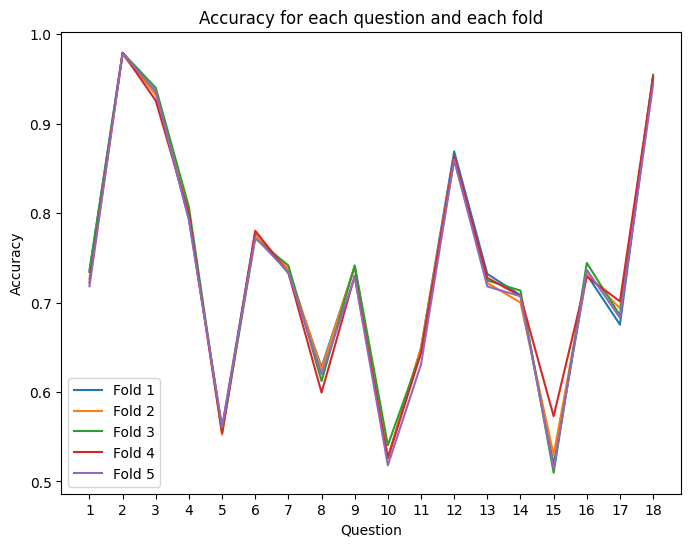

In [25]:
# create a plot
fig, ax = plt.subplots(figsize=(8,6))

# loop over the fold accuracies and plot them
for i in range(len(fold_accuracies)):
    accuracies = [fold_accuracies[i][q] for q in range(1,19)]
    ax.plot(range(1,19), accuracies, label=f'Fold {i+1}')

# set the title and labels for the plot
ax.set_title('Accuracy for each question and each fold')
ax.set_xlabel('Question')
ax.set_ylabel('Accuracy')

# add x-axis tick labels for the question numbers
ax.set_xticks(range(1,19))
ax.set_xticklabels(range(1,19))

# add a legend
ax.legend()

# show the plot
plt.show()


#### F1- score for each question and average score

In [54]:
# creating emplty lists to store the x and y values
x_values = []
y_values = []
# accuracy of each question
for q_no, f1_scores in fold_f1_dict.items():
    avg_f1 = np.mean(f1_scores)
    print(f"Question {q_no}: F1-Score {avg_f1:.4f}")
    x_values.append(q_no)
    y_values.append(avg_f1)
# average F1-score
avg_f1 = np.mean([np.mean(f1_scores) for f1_scores in fold_f1_dict.values()])
print(f"\nAverage F1-Score: {avg_f1:.4f}")
x_values.append(q_no)
y_values.append(avg_f1)

Question 1: F1-Score 0.8360
Question 2: F1-Score 0.9892
Question 3: F1-Score 0.9669
Question 4: F1-Score 0.8840
Question 5: F1-Score 0.7081
Question 6: F1-Score 0.8719
Question 7: F1-Score 0.8464
Question 8: F1-Score 0.7650
Question 9: F1-Score 0.8430
Question 10: F1-Score 0.6561
Question 11: F1-Score 0.7733
Question 12: F1-Score 0.9247
Question 13: F1-Score 0.0000
Question 14: F1-Score 0.8283
Question 15: F1-Score 0.0235
Question 16: F1-Score 0.8483
Question 17: F1-Score 0.8116
Question 18: F1-Score 0.9709

Average F1-Score: 0.7526


#### Plotting average F1-score for each question

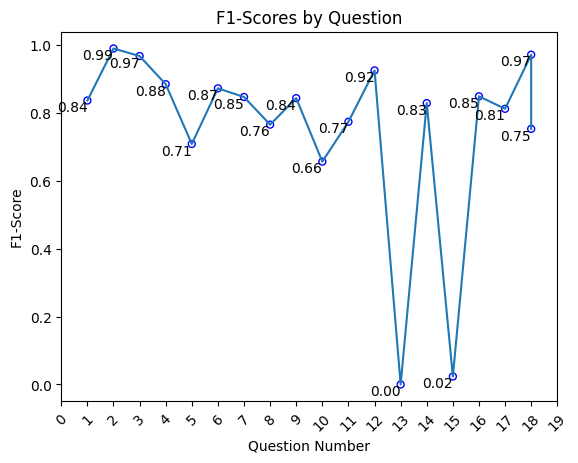

In [68]:
# create a line plot
plt.plot(x_values, y_values)
plt.scatter(x_values, y_values, s=25, facecolors='none', edgecolors='blue')
# add values to the circles
for x, y in zip(x_values, y_values):
    plt.text(x, y, f'{y:.2f}', ha='right', va='top')
# add labels to the plot
plt.xticks(range(0, len(x_values)+1, 1))
plt.title('F1-Scores by Question')
plt.xlabel('Question Number')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)

# show the plot
plt.show()

### xgboost

In [ ]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(all_users),18)), index=all_users)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=datasets, groups=datasets.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4,
    'use_label_encoder' : False}
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = datasets.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = target.loc[target.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = datasets.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = target.loc[target.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[features].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[features].astype('float32'), valid_y['correct']) ],
                verbose=0)
        print(f'{t}({clf.best_ntree_limit}), ',end='')
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[features].astype('float32'))[:,1]
        
    print()

In [14]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = target.loc[target.q == k+1].set_index('session').loc[all_users]
    true[k] = tmp.correct.values

In [15]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

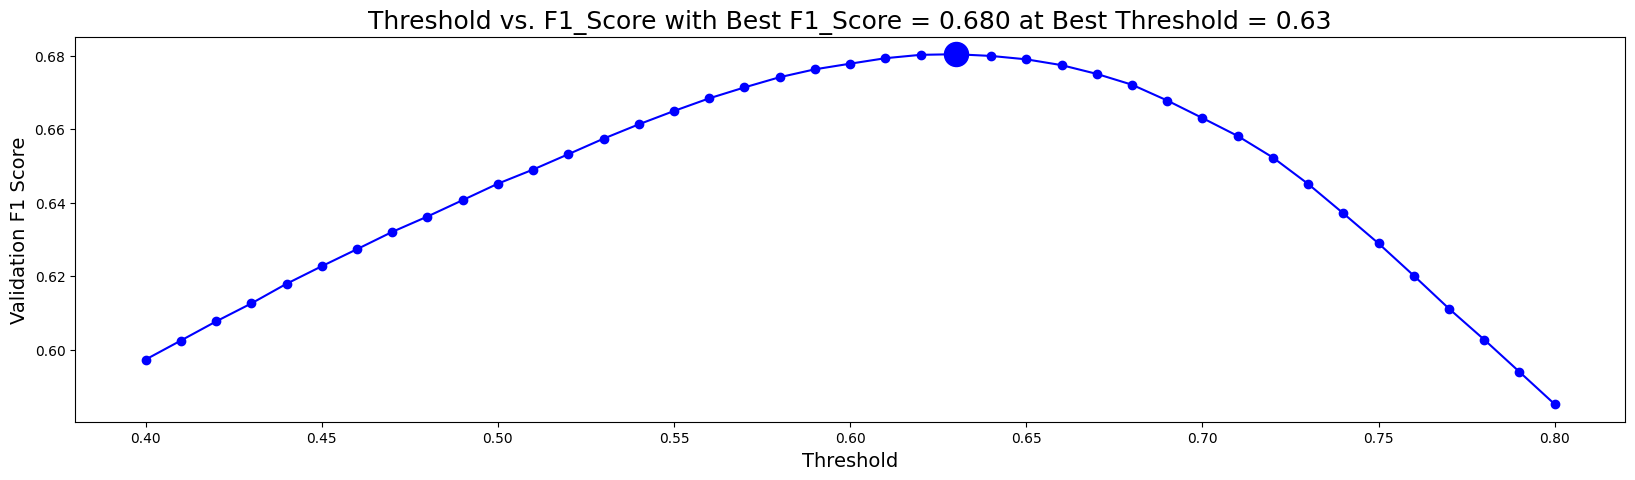

In [16]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

### Normalizing data to improve performance

In [21]:
from sklearn.preprocessing import MinMaxScaler

# create a MinMaxScaler object
scaler = MinMaxScaler()
cols = [c for c in datasets.columns if c != 'level_group']
# normalize the selected columns

datasets[cols]= scaler.fit_transform(datasets[cols])




In [22]:
print(datasets.shape)
datasets.head()

(70686, 45)


,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,...,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,0.75,0.000000,0.190476,0.166667,0.225,0.000072,0.052961,0.000000,0.594199,...,0.007137,0.026915,0.060284,0.001850,0.010499,0.032967,0.001626,0.075472,0.333333,0.000013
20090312431273200,13-22,0.75,0.000000,0.492063,0.583333,0.675,0.000873,0.853891,0.000000,0.419352,...,0.018481,0.236025,0.173759,0.005179,0.036745,0.054945,0.008130,0.056604,0.333333,0.000405
20090312431273200,5-12,0.75,0.000000,0.333333,0.500000,0.400,0.000299,0.369490,0.000000,0.602564,...,0.009941,0.196687,0.003546,0.008139,0.023622,0.043956,0.011382,0.018868,0.333333,0.000098
20090312433251036,0-4,1.00,0.333333,0.063492,0.083333,0.075,0.000082,0.049077,0.142857,0.477995,...,0.003059,0.018634,0.088652,0.003330,0.007874,0.000000,0.003252,0.037736,0.333333,0.000013
20090312433251036,13-22,1.00,1.000000,0.873016,0.916667,0.875,0.002096,0.872553,0.871429,0.545482,...,0.078002,0.281573,0.191489,0.028487,0.488189,0.098901,0.071545,0.094340,0.333333,0.003001


In [ ]:

gkf = GroupKFold(n_splits=5)
models = {}
# create an empty list to store the fold accuracies
xg_fold_accuracies = []
xg_accuracies = []
xg_fold_f1_scores = []

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=datasets, groups=datasets.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
     # create a dictionary to store the accuracies and f1 score for this fold
    xg_fold_dict = {}
    xg_evaluation_dict = {}
    xg_fold_f1_dict = {}
    
    xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4,
    'use_label_encoder' : False}
    
    fold_y_true = []
    fold_y_pred = []
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for q_no in range(1,19):
        
        question_acc = []
        question_f1 = []
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if q_no<=3: grp = '0-4'
        elif q_no<=13: grp = '5-12'
        elif q_no<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = datasets.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = target.loc[target.q==q_no].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = datasets.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = target.loc[target.q==q_no].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[features].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[features].astype('float32'), valid_y['correct']) ],
                verbose=0)
        print(f'{q_no}({clf.best_ntree_limit}), ',end='')
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{q_no}'] = clf
        
        
        # PREDICT VALIDATION SET
        y_pred = clf.predict(valid_x[features].astype('float32'))
        y_true = valid_y['correct']
        fold_y_pred.extend(y_pred)
        fold_y_true.extend(y_true)
    
        # Evaluate the trained model on the validation dataset and store the 

        accuracy = accuracy_score(y_true, y_pred)
        evaluation_dict[q_no] = accuracy
        xg_fold_dict[q_no] = accuracy
        question_acc.append(accuracy)

        f1 = f1_score(y_true, y_pred)
        xg_fold_f1_dict[q_no] = f1
        question_f1.append(f1)
    

    # append the fold accuracies to the list of fold accuracies
    xg_fold_accuracies.append(xg_fold_dict)
    xg_accuracies.append(question_acc)
    xg_fold_f1_scores.append(xg_fold_f1_dict)


In [26]:
# accuracy for each fold and question
for fold, fold_dict in enumerate(xg_fold_accuracies):
    print(f"Fold {fold+1} accuracies: {fold_dict}")

Fold 1 accuracies: {1: 0.7362614046255039, 2: 0.9764481222151495, 3: 0.9340123063865903, 4: 0.8084022915340547, 5: 0.6333545512412476, 6: 0.7808190112454912, 7: 0.7269255251432208, 8: 0.62974750689582, 9: 0.7432633142372163, 10: 0.6187141947803947, 11: 0.6488436240186718, 12: 0.8618714194780395, 13: 0.7368979418629323, 14: 0.7228941226395077, 15: 0.6218968809675366, 16: 0.7267133460640781, 17: 0.671546785486951, 18: 0.9482283046891576}
Fold 2 accuracies: {1: 0.7492043284532145, 2: 0.98026734563972, 3: 0.9340123063865903, 4: 0.8041587099511988, 5: 0.6346276257161044, 6: 0.7816677275620624, 7: 0.7368979418629323, 8: 0.6159558667515384, 9: 0.7405049862083598, 10: 0.6136218968809676, 11: 0.6609378315298111, 12: 0.8692976872480374, 13: 0.7146191385529387, 14: 0.72989603225122, 15: 0.6248673880755358, 16: 0.75493316359007, 17: 0.6929768724803734, 18: 0.9503500954805856}
Fold 3 accuracies: {1: 0.7328098471986417, 2: 0.9794142614601019, 3: 0.9376061120543294, 4: 0.8066638370118846, 5: 0.631578

In [21]:
# accuracy of each question
for name, value in evaluation_dict.items():
  print(f"question {name}: accuracy {value:.4f}")

print("\nAverage accuracy", sum(evaluation_dict.values())/18)

question 1: accuracy 0.7347
question 2: accuracy 0.9788
question 3: accuracy 0.9306
question 4: accuracy 0.8065
question 5: accuracy 0.6307
question 6: accuracy 0.7869
question 7: accuracy 0.7366
question 8: accuracy 0.6235
question 9: accuracy 0.7517
question 10: accuracy 0.6063
question 11: accuracy 0.6558
question 12: accuracy 0.8591
question 13: accuracy 0.7424
question 14: accuracy 0.7101
question 15: accuracy 0.6278
question 16: accuracy 0.7262
question 17: accuracy 0.6874
question 18: accuracy 0.9514

Average accuracy 0.7525820599886813


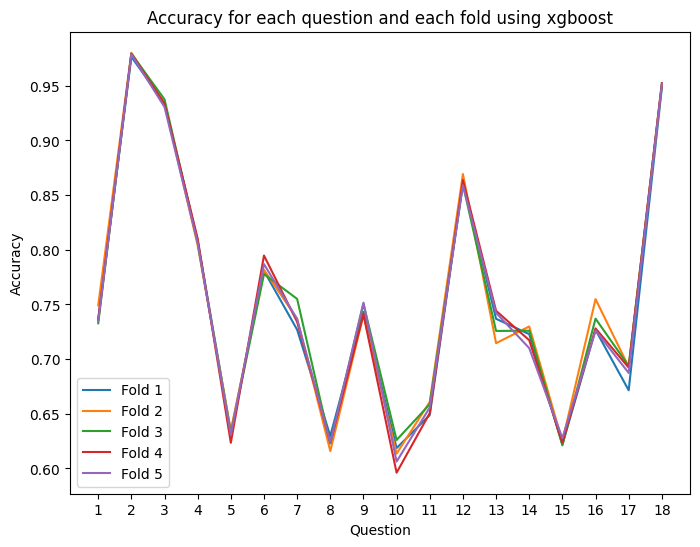

In [40]:
# create a plot
fig, ax = plt.subplots(figsize=(8,6))

# loop over the fold accuracies and plot them
for i in range(len(xg_fold_accuracies)):
    accuracies = [xg_fold_accuracies[i][q] for q in range(1,19)]
    ax.plot(range(1,19), accuracies, label=f'Fold {i+1}')

# set the title and labels for the plot
ax.set_title('Accuracy for each question and each fold using xgboost')
ax.set_xlabel('Question')
ax.set_ylabel('Accuracy')

# add x-axis tick labels for the question numbers
ax.set_xticks(range(1,19))
ax.set_xticklabels(range(1,19))

# add a legend
ax.legend()

# show the plot
plt.show()

In [22]:
# creating emplty lists to store the x and y values
xg_values = []
yg_values = []
# accuracy of each question
for q_no, f1_scores in xg_fold_f1_dict.items():
    avg_f1 = np.mean(f1_scores)
    print(f"Question {q_no}: F1-Score {avg_f1:.4f}")
    xg_values.append(q_no)
    yg_values.append(avg_f1)
# average F1-score
avg_f1 = np.mean([np.mean(f1_scores) for f1_scores in xg_fold_f1_dict.values()])
print(f"\nAverage F1-Score: {avg_f1:.4f}")
xg_values.append(q_no)
yg_values.append(avg_f1)

Question 1: F1-Score 0.8392
Question 2: F1-Score 0.9893
Question 3: F1-Score 0.9640
Question 4: F1-Score 0.8893
Question 5: F1-Score 0.6957
Question 6: F1-Score 0.8761
Question 7: F1-Score 0.8439
Question 8: F1-Score 0.7593
Question 9: F1-Score 0.8521
Question 10: F1-Score 0.6310
Question 11: F1-Score 0.7769
Question 12: F1-Score 0.9241
Question 13: F1-Score 0.2384
Question 14: F1-Score 0.8213
Question 15: F1-Score 0.6218
Question 16: F1-Score 0.8414
Question 17: F1-Score 0.8147
Question 18: F1-Score 0.9751

Average F1-Score: 0.7974


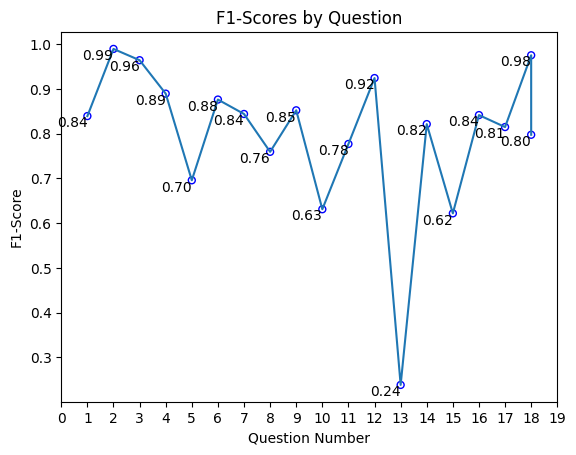

In [35]:
# create a line plot
plt.plot(xg_values, yg_values)
plt.scatter(xg_values, yg_values, s=25, facecolors='none', edgecolors='blue')
# add values to the circles
for x, y in zip(xg_values, yg_values):
    plt.text(x, y, f'{y:.2f}', ha='right', va='top')
# add labels to the plot
plt.xticks(range(0, len(xg_values)+1, 1))
plt.title('F1-Scores by Question')
plt.xlabel('Question Number')
plt.ylabel('F1-Score')

# show the plot
plt.show()

### Submission